# Simulating an ideal gas in OpenMM

## Preliminaries

First, we import OpenMM. At this stage we also import teh testsystems in openmmtools to create the simulation systemd more easily.

It's recommended that you always import this way:

In [1]:
from simtk import openmm, unit
from simtk.openmm import app
import numpy as np
from openmmtools.testsystems import *

### This is the source code we will use to create a system of ideal gas particles. 

class IdealGas(TestSystem):

    """Create an 'ideal gas' of noninteracting particles in a periodic box.

    Parameters
    ----------
    nparticles : int, optional, default=216
        number of particles
    mass : int, optional, default=39.9 * unit.amu
    temperature : int, optional, default=298.0 * unit.kelvin
    pressure : int, optional, default=1.0 * unit.atmosphere
    volume : None
        if None, defaults to (nparticles * temperature * unit.BOLTZMANN_CONSTANT_kB / pressure).in_units_of(unit.nanometers**3)

    Examples
    --------

    Create an ideal gas system.

    >>> gas = IdealGas()
    >>> system, positions = gas.system, gas.positions

    Create a smaller ideal gas system containing 64 particles.

    >>> gas = IdealGas(nparticles=64)
    >>> system, positions = gas.system, gas.positions

    """

    def __init__(self, nparticles=216, mass=39.9 * unit.amu, temperature=298.0 * unit.kelvin, pressure=1.0 * unit.atmosphere, volume=None, **kwargs):

        TestSystem.__init__(self, **kwargs)

        if volume is None:
            volume = (nparticles * temperature * unit.BOLTZMANN_CONSTANT_kB / pressure).in_units_of(unit.nanometers**3)

        # Create an empty system object.
        system = openmm.System()

        # Compute box size.
        length = volume**(1.0 / 3.0)
        a = unit.Quantity((length,           0 * unit.nanometer, 0 * unit.nanometer))
        b = unit.Quantity((0 * unit.nanometer,           length, 0 * unit.nanometer))
        c = unit.Quantity((0 * unit.nanometer, 0 * unit.nanometer, length))
        system.setDefaultPeriodicBoxVectors(a, b, c)

        # Add a null periodic nonbonded force to allow setting a barostat.
        nonbonded_force = openmm.NonbondedForce()
        nonbonded_force.setNonbondedMethod(openmm.NonbondedForce.CutoffPeriodic)
        for i in range(nparticles):
            nonbonded_force.addParticle(0.0, 1.0, 0.0)
        system.addForce(nonbonded_force)

        # Add particles.
        for index in range(nparticles):
            system.addParticle(mass)

        # Create initial coordinates using subrandom positions.
        positions = subrandom_particle_positions(nparticles, system.getDefaultPeriodicBoxVectors())

        # Create topology.
        topology = app.Topology()
        element = app.Element.getBySymbol('Ar')
        chain = topology.addChain()
        for particle in range(system.getNumParticles()):
            residue = topology.addResidue('Ar', chain)
            topology.addAtom('Ar', element, residue)
        self.topology = topology

        self.system, self.positions = system, positions
        self.ndof = 3 * nparticles

    def get_potential_expectation(self, state):
        """Return the expectation of the potential energy, computed analytically or numerically.

        Parameters
        ----------
        state : ThermodynamicState with temperature defined
            The thermodynamic state at which the property is to be computed.

        Returns
        -------
        potential_mean : simtk.unit.Quantity compatible with simtk.unit.kilojoules_per_mole
            The expectation of the potential energy.

        """

        return 0.0 * unit.kilojoules_per_mole

    def get_potential_standard_deviation(self, state):
        """Return the standard deviation of the potential energy, computed analytically or numerically.

        Parameters
        ----------
        state : ThermodynamicState with temperature defined
            The thermodynamic state at which the property is to be computed.

        Returns
        -------
        potential_stddev : simtk.unit.Quantity compatible with simtk.unit.kilojoules_per_mole
            potential energy standard deviation if implemented, or else None

        """

        return 0.0 * unit.kilojoules_per_mole

    def get_kinetic_expectation(self, state):
        """Return the expectation of the kinetic energy, computed analytically or numerically.

        Parameters
        ----------
        state : ThermodynamicState with temperature defined
            The thermodynamic state at which the property is to be computed.

        Returns
        -------
        potential_mean : simtk.unit.Quantity compatible with simtk.unit.kilojoules_per_mole
            The expectation of the potential energy.

        """

        return (3. / 2.) * kB * state.temperature

    def get_kinetic_standard_deviation(self, state):
        """Return the standard deviation of the kinetic energy, computed analytically or numerically.

        Parameters
        ----------
        state : ThermodynamicState with temperature defined
            The thermodynamic state at which the property is to be computed.

        Returns
        -------
        potential_stddev : simtk.unit.Quantity compatible with simtk.unit.kilojoules_per_mole
            potential energy standard deviation if implemented, or else None

        """

        return (3. / 2.) * kB * state.temperature

    def get_volume_expectation(self, state):
        """Return the expectation of the volume, computed analytically.

        Parameters
        ----------
        state : ThermodynamicState with temperature and pressure defined
            The thermodynamic state at which the property is to be computed.

        Returns
        -------
        volume_mean : simtk.unit.Quantity compatible with simtk.unit.nanometers**3
            The expectation of the volume at equilibrium.

        Notes
        -----
        The true mean volume is used, rather than the large-N limit.

        """

        if not state.pressure:
            box_vectors = self.system.getDefaultPeriodicBoxVectors()
            volume = box_vectors[0][0] * box_vectors[1][1] * box_vectors[2][2]
            return volume

        N = self._system.getNumParticles()
        return ((N + 1) * unit.BOLTZMANN_CONSTANT_kB * state.temperature / state.pressure).in_units_of(unit.nanometers**3)

    def get_volume_standard_deviation(self, state):
        """Return the standard deviation of the volume, computed analytically.

        Parameters
        ----------
        state : ThermodynamicState with temperature and pressure defined
            The thermodynamic state at which the property is to be computed.

        Returns
        -------
        volume_stddev : simtk.unit.Quantity compatible with simtk.unit.nanometers**3
            The standard deviation of the volume at equilibrium.

        Notes
        -----
        The true mean volume is used, rather than the large-N limit.

        """

        if not state.pressure:
            return 0.0 * unit.nanometers**3

        N = self._system.getNumParticles()
        return (numpy.sqrt(N + 1) * unit.BOLTZMANN_CONSTANT_kB * state.temperature / state.pressure).in_units_of(unit.nanometers**3)


### Questions:

1.) Which gas is used as default?

2.) Why is it an ideal gas?

3.) What is the kinetic energy of the system?

In [2]:
# Create a ideal gas
gas = IdealGas(nparticles=1000,temperature=120*unit.kelvin)

Now we define the thermodynamic variables and a copy of the system and the positions

In [3]:
pressure = 1*unit.atmospheres
temperature = 120*unit.kelvin
[system, positions] = [gas.system, gas.positions]

This is the collision rate of the Langevin integrator and the timestep which will be used.

In [4]:
collision_rate = 5/unit.picoseconds
timestep = 2.5*unit.femtoseconds

Setting up the simulation and minimizing the potential energy ...

In [5]:
# Create a context
integrator = openmm.LangevinIntegrator(temperature, collision_rate, timestep)
context = openmm.Context(system, integrator)
context.setPositions(positions)

# Minimize energy
print('Minimizing energy...')
openmm.LocalEnergyMinimizer.minimize(context)

Minimizing energy...


### Question:

Is it necessary to minimize the potential energy?

In [6]:
state = context.getState(getEnergy=True)
state.getPotentialEnergy()

Quantity(value=0.0, unit=kilojoule/mole)

We will simulate this system in total for 5000 steps and write the kinetic energy every 10 step

In [11]:
niterations = 50000 
nsteps = 10

Create an array to store the kinetic energy every 10 steps and simulate ...

In [12]:
u = np.zeros(niterations, np.float64)
for iteration in range(niterations):
        # print('iteration  %5d' % (iteration))
        # Run some dynamics
        integrator.step(nsteps)
        # Compute energies at all alchemical states
        u[iteration] = context.getState(getEnergy=True).getKineticEnergy() / unit.kilojoule_per_mole

We will now plot the kinetic energy 

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

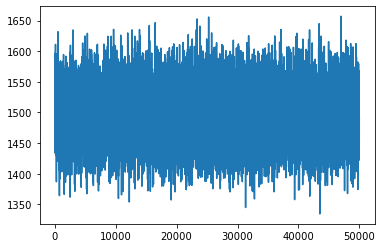

In [14]:
plt.plot(u)

Questions:

1.) Redo the simulation for the same number of steps without redefining the context class. Why is the kinetic energy more constant now then before?

2.) What is the energy in Joule you expect to get? 

3.) How can you achieve a more constant kinetic energy?